In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm

In [121]:
v10_cb = pd.read_csv("v10_cb.csv")
v10_p4 = pd.read_csv("v10_p4.csv")

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: x - v10_cb["timestamp"][0])
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: x - v10_p4["timestamp"][0])

v10_cb["timestamp"] = v10_cb["timestamp"].dt.seconds + v10_cb["timestamp"].dt.microseconds/10e6
v10_p4["timestamp"] = v10_p4["timestamp"].dt.seconds + v10_p4["timestamp"].dt.microseconds/10e6

In [122]:
dt_cb = v10_cb["timestamp"]
dt_p4 = v10_p4["timestamp"]

cb = v10_cb["val"]
p4 = v10_p4["val"]

In [123]:
np.min(cb)

0.280737

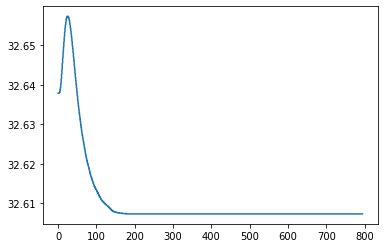

In [124]:
plt.plot(dt_p4,p4)
plt.show()

In [125]:
epochs = 3
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-3, momentum = 0.9)
t0 = tf.Variable(tf.random.uniform((1,),minval=-100, maxval=100, name='t0'))
t1 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t1'))
t2 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t2'))
loss_metric = tf.keras.metrics.Mean()

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

for epoch in range(epochs):
    pbar = tqdm(range(len(p4)))
    
    for batch_id in pbar:
        time = dt_p4[batch_id]
        y = p4[batch_id]

        with tf.GradientTape() as tape:
            # y = A+B*(1+C*e**(-t/D)+E*e**(-t/F))
            e1 = np.exp(-time/tf.abs(t1))
            e2 = np.exp(-time/tf.abs(t2))
            c1 = tf.divide(tf.subtract(t0,tf.abs(t1)),tf.subtract(tf.abs(t1),tf.abs(t2)))
            c2 = tf.divide(tf.subtract(t0,tf.abs(t2)),tf.subtract(tf.abs(t2),tf.abs(t1)))
            h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
            h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
            h = 1 + h1 + h2
            y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
            loss = 10000*loss_compute(y, y_)
            # print(e1," , ", e2," , ",c1," , ",c2," , ",h1," , ",h2)

            gradients = tape.gradient(loss,[t0,t1, t2])
            optimizer.apply_gradients(zip(gradients, [t0,t1,t2]))

            # Tracking progress
            loss_metric(loss)
            pbar.set_description('Training Loss: %.3f' % 
                                 loss_metric.result().numpy())

Training Loss: 0.765: 100%|██████████| 7226/7226 [01:17<00:00, 93.68it/s]


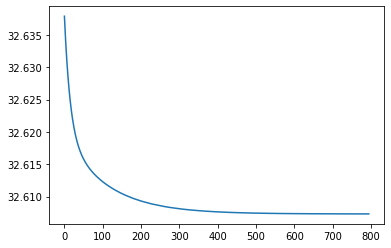

In [126]:
e1 = np.exp(-dt_p4/tf.abs(t1))
e2 = np.exp(-dt_p4/tf.abs(t2))
c1 = tf.divide(tf.subtract(t0,tf.abs(t1)),tf.subtract(tf.abs(t1),tf.abs(t2)))
c2 = tf.divide(tf.subtract(t0,tf.abs(t2)),tf.subtract(tf.abs(t2),tf.abs(t1)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h = 1 + h1 + h2
y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
plt.plot(dt_p4,y_)
plt.show()

In [127]:
print(t0)
print(t1)
print(t2)

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([72.071396], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([15.231606], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([110.21217], dtype=float32)>


<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-61.46864], dtype=float32)>

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-4.853584], dtype=float32)>

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([38.946236], dtype=float32)>